# Problem

**10×10 Gridworld**

**Layout (row-major indices)**

Legend: **S** start, **G** goal (terminal), **P** pit (terminal), **#** wall, **.** empty

```
r\c  0 1 2 3 4 5 6 7 8 9
0    S . . . # . . . . .
1    . # . . # . . # P .
2    . # # . . . . # . .
3    . . P . # . . # . .
4    # . # # # # # # . #
5    . . . . # . . P . .
6    . P # . # . # . . .
7    . . # . . P # . . .
8    . . # . # . # # . .
9    . . . . # . . . . G
```

**State space**

$$
\mathcal{X}={0,1,\dots,99},\quad x=10r+c
$$

* **Goal (absorbing):** $x_G=99$
* **Pits (absorbing):**
  $
  \mathcal{X}_{\text{pit}}={18,32,57,61,75,88}
  $
* **Walls (impassable):**
  $
  \mathcal{X}_{\text{wall}}={4,11,14,17,21,22,27,34,37,40,42,43,44,45,46,47,49,54,62,64,66,72,76,82,84,86,87,94}
  $

Terminal set:
$
\mathcal{T}={99}\cup \mathcal{X}_{\text{pit}}
$

**Action space**

$$
\mathcal{A}={0,1,2,3}
$$
where (0=) Up, (1=) Down, (2=) Left, (3=) Right.

**Transition dynamics (deterministic)**

Let $x\mapsto(r,c)$ by $r=\lfloor x/10\rfloor,\ c=x\bmod 10$.

* If $x\in\mathcal{T}$, then $\text{next\_state}(x,a)=x$ $absorbing$.
* Otherwise, compute the intended neighbor $(r',c')$ from action $a$.
* If $(r',c')$ is outside the grid, **stay**.
* Let $x'=10r'+c'$. If $x'\in\mathcal{X}_{\text{wall}}$, **stay**.

Transition matrix shape:
$$
P\in\mathbb{R}^{(|\mathcal{X}||\mathcal{A}|)\times|\mathcal{X}|}=\mathbb{R}^{400\times 100},
$$
with
$$
P[(x,a),x']=1 \iff x'=\text{next\_state}(x,a)
$$

**Reward model (standard step cost + terminal outcomes)**

Reward based on the **next state**:
$$
r(x,a)=
\begin{cases}
+1 & \text{if } \text{next\_state}(x,a)=99,\
-5 & \text{if } \text{next\_state}(x,a)\in \mathcal{X}_{\text{pit}},\
-0.1 & \text{otherwise.}
\end{cases}
$$

**Initial state**

$$
x_0=0.
$$

In [50]:
%load_ext autoreload
%autoreload 2

import os
import random
import torch
import pandas as pd
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
# Add project root to the Python path
sys.path.append(str(PROJECT_ROOT))
# Define dataset path
DATASET_PATH = PROJECT_ROOT / "datasets" / "10grid_wall.csv"
DATASET_PATH_OPT = PROJECT_ROOT / "datasets" / "10grid_wall_opt.csv"
DATASET_PATH_20k = PROJECT_ROOT / "datasets" / "10grid_wall_20k.csv"
DATASET_PATH_20k_greedy = PROJECT_ROOT / "datasets" / "10grid_wall_greedy.csv"


from fogas_torch import PolicySolver, EnvDataCollector
from fogas_torch.algorithm import (
    FOGASSolverVectorized,
    FOGASOracleSolverVectorized,
    FOGASHyperOptimizer,
    FOGASEvaluator,
)

seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


# Tabular Features

In [133]:
# ===== 10x10 Four-Rooms Grid (harder) =====

states  = torch.arange(100, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N = len(states)     # 100
A = len(actions)    # 4
gamma = 0.9

x_0 = 0  # fixed initial state

goal = 99  # absorbing terminal state

# pits (absorbing terminal states)
pits = {18, 32, 57, 61, 75}

# walls (impassable)
walls = {
    4, 11, 14, 17, 21, 22, 27, 34, 37,
    40, 42, 43, 44, 45, 46, 47, 49,
    54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94
}

# ---------- Tabular features ----------
def phi(x, a):
    vec = torch.zeros(N * A, dtype=torch.float64)
    vec[int(x) * A + int(a)] = 1.0
    return vec

# ---------- Reward weights (tabular) ----------
step_cost = -0.1
goal_reward = 1.0
pit_reward  = -5.0

omega = torch.full((N * A,), step_cost, dtype=torch.float64)

# override terminal rewards (all actions in terminal states)
omega[goal * A : goal * A + A] = goal_reward
for p in pits:
    omega[p * A : p * A + A] = pit_reward

# ---------- Helpers: index <-> (row, col) ----------
def to_rc(s):  return divmod(s, 10)
def to_s(r, c): return r * 10 + c

# ---------- Dynamics ----------
def next_state(s, a):
    # absorbing terminals
    if s == goal or s in pits:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r - 1), c
    elif a == 1:    # Down
        r2, c2 = min(9, r + 1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c - 1)
    elif a == 3:    # Right
        r2, c2 = r, min(9, c + 1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp in walls:
        return s

    return sp

# ---------- Backward feature map psi(x') ----------
def psi(xp):
    v = torch.zeros(N * A, dtype=torch.float64)
    for x in states:
        for a in actions:
            if next_state(int(x), int(a)) == xp:
                v[int(x) * A + int(a)] = 1.0
    return v

# ---------- Build solver ----------
mdp = PolicySolver(
    states=states,
    actions=actions,
    phi=phi,
    omega=omega,
    gamma=gamma,
    x0=x_0,
    psi=psi
)


### Oracle

In [7]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1000,
    device=device,
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)



================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      9255128.526390366
T (iterations):                1000   (overridden → 1000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000263
rho:                            66.292053
eta:                            0.000002
D_theta:                    63.245553
beta (ridge):             0.000003
D_pi (derived):           16.651092





=== FOGAS Hyperparameter Optimization ===
[Theory] metric = 0.3760
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=2.6159e+00, rho=1.0000e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing rho
[After rho*] alpha=2.6159e+00, rho=1.5078e-02, eta=1.5215e-06 | metric = 0.1000

Optimizing eta
[After eta*] alpha=2.6159e+00, rho=1.5078e-02, eta=1.0000e-02 | metric = 0.0564


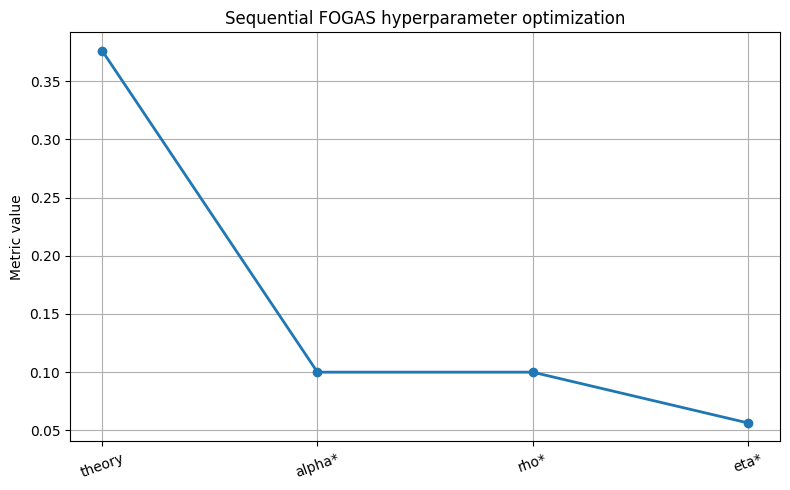

In [8]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=7,
    print_main=True, 
    num_runs=1,
    random_candidates=10,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [9]:
solver.run(T = 10000, alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)

FOGAS Oracle: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 170.64it/s]


tensor([[ 1.0470e-15,  3.9260e-01,  1.0470e-15,  6.0740e-01],
        [ 6.0284e-04,  6.0284e-04,  4.7697e-35,  9.9879e-01],
        [ 6.4261e-09,  5.0000e-01,  7.8262e-27,  5.0000e-01],
        [ 1.8498e-03,  9.9630e-01,  5.9501e-18,  1.8498e-03],
        [ 4.3004e-10,  4.3004e-10,  7.7389e-63,  1.0000e+00],
        [ 3.1907e-14,  3.4392e-24,  3.1907e-14,  1.0000e+00],
        [ 1.1634e-22,  3.5100e-39,  4.7072e-38,  1.0000e+00],
        [ 1.0997e-36,  1.0997e-36,  1.7062e-63,  1.0000e+00],
        [ 2.0615e-59,  0.0000e+00, 8.3471e-100,  1.0000e+00],
        [ 1.0513e-89,  1.0000e+00, 1.9356e-152,  1.0513e-89],
        [ 1.1386e-25,  9.9714e-01,  1.4301e-03,  1.4301e-03],
        [ 3.7782e-33,  8.1219e-09,  3.8819e-42,  1.0000e+00],
        [ 5.9501e-18,  1.8498e-03,  1.8498e-03,  9.9630e-01],
        [ 1.9147e-11,  9.9153e-01,  1.9147e-11,  8.4747e-03],
        [ 3.7130e-06,  2.3832e-20,  4.4538e-44,  1.0000e+00],
        [ 6.3161e-01,  8.6018e-17,  7.5381e-09,  3.6839e-01],
        

In [11]:
evaluator.print_optimal_path(goal_state=99)


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Goal State: 99
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 3       │ Reward:  -0.100 │ → 26
  Step   8 │ State: 26       │ Action: 0       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7    

### Dataset Collection

In [134]:
walls = [4, 11, 14, 17, 21, 22, 27, 34, 37, 40, 42, 43, 44, 45, 46, 47, 49, 54, 62, 64, 66, 72, 76, 82, 84, 86, 87, 94]
pits = [18, 32, 57, 61, 75]
goal = [99]

# Probabilities: 
# 80% of trajectories start in a random "safe" state
# 20% of trajectories start in the fixed initial state (x0)
reset_options = {
    'random': 0.5, 
    'x0': 0.5
}

# Initialize the collector with these options
collector = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    restricted_states=walls,  # These will never be starting states
    terminal_states=pits + goal, # Terminal states are also excluded
    reset_probs=reset_options,
    max_steps=50
)


# Collect mixed dataset: 90% random, 10% optimal (as per your proportions)
collector.collect_mixed_dataset(
    policies=["random", mdp.pi_star],  # mdp.pi_star is a torch.Tensor, handled automatically
    proportions=[0.7, 0.3],            # 90-10 split
    n_steps=20000,
    episode_based=True,                # Entire episodes use one policy
    save_path=str(DATASET_PATH_20k),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 20000
Total episodes: 683
Mode: Episode-based

Policy Distribution:
  Policy 0: 16132 steps (80.7%) | Target: 70.0% | Episodes: 505
  Policy 1:  3868 steps (19.3%) | Target: 30.0% | Episodes: 179

✅ Mixed dataset saved to: /shared/home/mauro.diaz/work/datasets/10grid_wall_20k.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,2,-0.1,0,0
2,0,2,0,0,-0.1,0,0
3,0,3,0,2,-0.1,0,0
4,0,4,0,3,-0.1,1,0
...,...,...,...,...,...,...,...
19995,683,5,88,1,-0.1,98,0
19996,683,6,98,1,-0.1,98,0
19997,683,7,98,1,-0.1,98,0
19998,683,8,98,1,-0.1,98,0


In [35]:
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer

analyzer = DatasetAnalyzer(DATASET_PATH_20k)

# Perform the analysis
analyzer.analyze_custom_stats(
    states=[13, 23, 24,41, 48, 8],
    pairs=[(15, "Left"), (15, "Right")]
)


     CUSTOM DATASET ANALYSIS

[State Visit Counts]
  State  13:    903
  State  23:    429
  State  24:    349
  State  41:    206
  State  48:     43
  State   8:     98

[State-Action Pair Counts]
  Pair (15, Left):     52
  Pair (15, Right):     67




In [135]:
reset_options2 = {
    'random': 0, 
    'x0': 1
}

# Initialize the collector with these options
collector2 = EnvDataCollector(
    mdp=mdp,
    env_name="10grid_wall",
    initial_states = [0, 68],
    reset_probs={'custom': 1.0},
    restricted_states=walls,  # These will never be starting states
    terminal_states=pits + goal, # Terminal states are also excluded
    max_steps=50
)

# Create an epsilon-greedy pi_star (30% optimal, 70% random)
epsilon_policy = (mdp.pi_star, 0.3)

# Use it in your mixed collection as before
collector2.collect_mixed_dataset(
    policies=[epsilon_policy, "random"],  # (base_policy, epsilon) tuple
    proportions=[1, 0],               # Relative amounts of each policy
    n_steps=20000,
    episode_based=True,                   
    save_path=str(DATASET_PATH_20k_greedy),
    verbose=True
)


  MIXED DATASET COLLECTION SUMMARY (TORCH)
Total transitions: 20000
Total episodes: 1068
Mode: Episode-based

Policy Distribution:
  Policy 0: 20000 steps (100.0%) | Target: 100.0% | Episodes: 1069
  Policy 1:     0 steps ( 0.0%) | Target:  0.0% | Episodes: 0

✅ Mixed dataset saved to: /shared/home/mauro.diaz/work/datasets/10grid_wall_greedy.csv


,episode,step,state,action,reward,next_state,policy_id
0,0,0,0,0,-0.1,0,0
1,0,1,0,2,-0.1,0,0
2,0,2,0,2,-0.1,0,0
3,0,3,0,3,-0.1,1,0
4,0,4,1,3,-0.1,2,0
...,...,...,...,...,...,...,...
19995,1068,2,0,3,-0.1,1,0
19996,1068,3,1,1,-0.1,1,0
19997,1068,4,1,3,-0.1,2,0
19998,1068,5,2,1,-0.1,12,0


In [125]:
from fogas.dataset_collection.dataset_analyzer import DatasetAnalyzer

analyzer2 = DatasetAnalyzer(DATASET_PATH_20k_greedy)

# Perform the analysis
analyzer2.analyze_custom_stats(
    states=[13, 23, 24,41, 48, 8],
    pairs=[(58, "Left"), (58, "Right"), (58, "Down")]
)


     CUSTOM DATASET ANALYSIS

[State Visit Counts]
  State  13:   1202
  State  23:   1052
  State  24:    977
  State  41:      0
  State  48:    163
  State   8:    456

[State-Action Pair Counts]
  Pair (58, Left):     39
  Pair (58, Right):     36
  Pair (58, Down):    102




### Empirical

In [39]:
solver_e1 = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH_20k),
    T=15000,
    device=device,
    print_params= True
)
evaluator_e1 = FOGASEvaluator(solver_e1)
optimizer_e1 = FOGASHyperOptimizer(solver=solver_e1,metric_callable=evaluator_e1.get_metric("reward"), seed=seed)



Device: cuda
Dataset: /shared/home/mauro.diaz/work/datasets/10grid_wall_20k.csv (n=20000)

================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           20000
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510.257052780733
T (iterations):                15000   (overridden → 15000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000068
rho:                            1660.981477
eta:                            0.000000
D_theta:                    63.245553
beta (ridge):             0.000000
D_pi (derived):           64.489403




In [ ]:
# Use the fixed values
rho_star_e1 = 0.05
eta_star_e1 = 0.002

alpha_star_e1, grid_values, metric_values = optimizer_e1.simple_grid_search(
    param_name="alpha",
    bounds=(0.0001, 5.0),
    n_points=20,
    fixed_params={"eta": eta_star_e1, "rho": rho_star_e1},
    log_scale=True,  # Linear spacing
    num_runs=1,
    print_results=True)

alpha=0.0001, metric=1.1550
alpha=0.0001767, metric=1.1917
alpha=0.0003123, metric=1.2131
alpha=0.000552, metric=1.2359
alpha=0.0009756, metric=1.2472
alpha=0.001724, metric=1.2180
alpha=0.003047, metric=1.1639
alpha=0.005385, metric=1.1489
alpha=0.009517, metric=1.1174
alpha=0.01682, metric=1.2168
alpha=0.02973, metric=0.6065
alpha=0.05254, metric=1.1095
alpha=0.09285, metric=1.1996
alpha=0.1641, metric=1.2380
alpha=0.29, metric=0.1000
alpha=0.5125, metric=0.1000
alpha=0.9058, metric=0.1000
alpha=1.601, metric=1.3307
alpha=2.829, metric=0.1051
alpha=5, metric=0.1000


In [48]:
# Run solver with best alpha and fixed rho, eta
solver_e1.run(alpha=0.001, eta=0.002, rho=0.05, tqdm_print=True, T=8000)
evaluator_e1.print_policy()

FOGAS: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:34<00:00, 232.76it/s]

  State 0: π(a=0|s=0) = 0.10  π(a=1|s=0) = 0.37  π(a=2|s=0) = 0.09  π(a=3|s=0) = 0.44  --> best action: 3
  State 1: π(a=0|s=1) = 0.22  π(a=1|s=1) = 0.22  π(a=2|s=1) = 0.03  π(a=3|s=1) = 0.53  --> best action: 3
  State 2: π(a=0|s=2) = 0.23  π(a=1|s=2) = 0.33  π(a=2|s=2) = 0.07  π(a=3|s=2) = 0.36  --> best action: 3
  State 3: π(a=0|s=3) = 0.26  π(a=1|s=3) = 0.33  π(a=2|s=3) = 0.16  π(a=3|s=3) = 0.25  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.23  π(a=1|s=5) = 0.11  π(a=2|s=5) = 0.23  π(a=3|s=5) = 0.44  --> best action: 3
  State 6: π(a=0|s=6) = 0.19  π(a=1|s=6) = 0.07  π(a=2|s=6) = 0.09  π(a=3|s=6) = 0.65  --> best action: 3
  State 7: π(a=0|s=7) = 0.17  π(a=1|s=7) = 0.17  π(a=2|s=7) = 0.03  π(a=3|s=7) = 0.63  --> best action: 3
  State 8: π(a=0|s=8) = 0.15  π(a=1|s=8) = 0.69  π(a=2|s=8) = 0.03  π(a=3|s=8) = 0.13  --> best action: 1
  State 9: π(a=0|s=9) = 0.17  π(a=1|s=9) = 0.4

In [49]:
evaluator_e1.print_optimal_path()


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 3       │ Reward:  -0.100 │ → 3
  Step   3 │ State: 3        │ Action: 1       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 0       │ Reward:  -0.100 │ → 5
  Step   9 │ State: 5        │ Action: 3       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7        │ Action: 3 

In [136]:
solver_e2 = FOGASSolverVectorized(
    mdp=mdp,
    csv_path=str(DATASET_PATH_20k_greedy),
    T=15000,
    device=device,
    print_params= True
)
evaluator_e2 = FOGASEvaluator(solver_e2)
optimizer_e2 = FOGASHyperOptimizer(solver=solver_e2,metric_callable=evaluator_e2.get_metric("reward"), seed=seed)


Device: cuda
Dataset: /shared/home/mauro.diaz/work/datasets/10grid_wall_greedy.csv (n=20000)

================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           20000
Feature norm bound R:     1.0000
Num states N:             100
Num actions A:            4
Feature dim d:            400
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510.257052780733
T (iterations):                15000   (overridden → 15000)

FOGAS Hyperparameters
---------------------
alpha:                        0.000068
rho:                            1660.981477
eta:                            0.000000
D_theta:                    63.245553
beta (ridge):             0.000000
D_pi (derived):           64.489403




In [137]:
# Run solver with best alpha and fixed rho, eta
solver_e2.run(alpha=0.001 / 2, eta=0.0002, rho=0.05, tqdm_print=True, T=12000)
evaluator_e2.print_policy()

FOGAS:   0%|                                                                                                              | 0/12000 [00:00<?, ?it/s]

FOGAS: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 12000/12000 [00:51<00:00, 232.85it/s]

  State 0: π(a=0|s=0) = 0.07  π(a=1|s=0) = 0.07  π(a=2|s=0) = 0.05  π(a=3|s=0) = 0.81  --> best action: 3
  State 1: π(a=0|s=1) = 0.06  π(a=1|s=1) = 0.06  π(a=2|s=1) = 0.02  π(a=3|s=1) = 0.86  --> best action: 3
  State 2: π(a=0|s=2) = 0.06  π(a=1|s=2) = 0.80  π(a=2|s=2) = 0.02  π(a=3|s=2) = 0.12  --> best action: 1
  State 3: π(a=0|s=3) = 0.11  π(a=1|s=3) = 0.78  π(a=2|s=3) = 0.03  π(a=3|s=3) = 0.07  --> best action: 1
  State 4: π(a=0|s=4) = 0.25  π(a=1|s=4) = 0.25  π(a=2|s=4) = 0.25  π(a=3|s=4) = 0.25  --> best action: 0
  State 5: π(a=0|s=5) = 0.10  π(a=1|s=5) = 0.05  π(a=2|s=5) = 0.11  π(a=3|s=5) = 0.74  --> best action: 3
  State 6: π(a=0|s=6) = 0.10  π(a=1|s=6) = 0.05  π(a=2|s=6) = 0.05  π(a=3|s=6) = 0.79  --> best action: 3
  State 7: π(a=0|s=7) = 0.10  π(a=1|s=7) = 0.10  π(a=2|s=7) = 0.05  π(a=3|s=7) = 0.75  --> best action: 3
  State 8: π(a=0|s=8) = 0.12  π(a=1|s=8) = 0.05  π(a=2|s=8) = 0.06  π(a=3|s=8) = 0.77  --> best action: 3
  State 9: π(a=0|s=9) = 0.12  π(a=1|s=9) = 0.7

In [138]:
evaluator_e2.print_optimal_path()


  OPTIMAL PATH VISUALIZATION - Learned Policy (π_FOGAS)

Initial State: 0
Discount Factor (γ): 0.9

----------------------------------------------------------------------

  Step   0 │ State: 0        │ Action: 3       │ Reward:  -0.100 │ → 1
  Step   1 │ State: 1        │ Action: 3       │ Reward:  -0.100 │ → 2
  Step   2 │ State: 2        │ Action: 1       │ Reward:  -0.100 │ → 12
  Step   3 │ State: 12       │ Action: 3       │ Reward:  -0.100 │ → 13
  Step   4 │ State: 13       │ Action: 1       │ Reward:  -0.100 │ → 23
  Step   5 │ State: 23       │ Action: 3       │ Reward:  -0.100 │ → 24
  Step   6 │ State: 24       │ Action: 3       │ Reward:  -0.100 │ → 25
  Step   7 │ State: 25       │ Action: 0       │ Reward:  -0.100 │ → 15
  Step   8 │ State: 15       │ Action: 3       │ Reward:  -0.100 │ → 16
  Step   9 │ State: 16       │ Action: 0       │ Reward:  -0.100 │ → 6
  Step  10 │ State: 6        │ Action: 3       │ Reward:  -0.100 │ → 7
  Step  11 │ State: 7        │ Action: 

# Funky Features

## Definition

## Testing

In [78]:
# -----------------------------
# Problem definition
# -----------------------------
states = torch.arange(9, dtype=torch.int64)
actions = torch.arange(4, dtype=torch.int64)
N = len(states)
A = len(actions)
gamma = 0.9

x_0 = 0

goal = 8   # absorbing terminal state
pit  = 5   # absorbing terminal state
wall = 4   # wall cell

step_cost   = -0.01
goal_reward = 1.0
pit_reward  = -1.0

# -----------------------------
# Helpers: state index <-> (row, col)
# -----------------------------
def to_rc(s):  return divmod(int(s), 3)
def to_s(r,c): return int(r)*3 + int(c)

# -----------------------------
# Deterministic dynamics
# -----------------------------
def next_state(s, a):
    s = int(s); a = int(a)

    # absorbing terminals
    if s == goal or s == pit:
        return s

    r, c = to_rc(s)

    if a == 0:      # Up
        r2, c2 = max(0, r-1), c
    elif a == 1:    # Down
        r2, c2 = min(2, r+1), c
    elif a == 2:    # Left
        r2, c2 = r, max(0, c-1)
    elif a == 3:    # Right
        r2, c2 = r, min(2, c+1)
    else:
        raise ValueError("Invalid action")

    sp = to_s(r2, c2)

    # wall blocks transition
    if sp == wall:
        return s

    return sp

# -----------------------------
# Build explicit transition matrix P: shape (N*A, N)
# Row corresponds to (x,a) in row-major order: idx = x*A + a
# -----------------------------
P = torch.zeros((N * A, N), dtype=torch.float64)
for x in states:
    for a in actions:
        idx = int(x) * A + int(a)
        xp = next_state(x, a)
        P[idx, xp] = 1.0

# -----------------------------
# action features: [1, dr, dc] in R^3
# state features: row_onehot ⊗ col_onehot in R^9 (exact state one-hot)
# phi(x,a) = kron(phi_action(a), phi_state(x)) in R^(3*9)=R^27
# -----------------------------
d_state  = 9
d_action = 3
d_feat   = d_state * d_action  # 27

def phi_state(x):
    r, c = to_rc(x)
    row = torch.zeros(3, dtype=torch.float64); row[r] = 1.0
    col = torch.zeros(3, dtype=torch.float64); col[c] = 1.0
    return torch.kron(row, col)  # R^9

def phi_action(a):
    a = int(a)
    if a == 0:   dr, dc = -1.0,  0.0  # Up
    elif a == 1: dr, dc =  1.0,  0.0  # Down
    elif a == 2: dr, dc =  0.0, -1.0  # Left
    elif a == 3: dr, dc =  0.0,  1.0  # Right
    else:
        raise ValueError("Invalid action")
    return torch.tensor([1.0, dr, dc], dtype=torch.float64)  # R^3

def phi(x, a):
    return torch.kron(phi_action(a), phi_state(x))  # R^27

# -----------------------------
# Exact omega for state-only reward:
# r(x,a) = r_state(x) for all actions
# Put r_state into the "bias block" omega[0:9], rest zeros.
# -----------------------------
r_state = torch.full((N,), step_cost, dtype=torch.float64)
r_state[goal] = goal_reward
r_state[pit]  = pit_reward

omega = torch.zeros(d_feat, dtype=torch.float64)
omega[:d_state] = r_state  # exact

mdp = PolicySolver(states=states, actions=actions, phi=phi, omega=omega, gamma=gamma, x0=x_0, P=P)


### Oracle

In [79]:
solver = FOGASOracleSolverVectorized(
    mdp=mdp, 
    cov_matrix="identity", 
    print_params=True, 
    T=1500,
    device=device,
)
evaluator = FOGASEvaluator(solver)
optimizer = FOGASHyperOptimizer(solver=solver,metric_callable=evaluator.get_metric("reward"), seed=seed)



================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           10000000.0
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      18510257.052780736
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            4.559519
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269





=== FOGAS Hyperparameter Optimization ===
[Initial] metric = 0.0647
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.1345e+00, rho=5.0000e+00, eta=1.3013e-05 | metric = -0.6507

Optimizing rho
[After rho*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.3013e-05 | metric = -0.6515

Optimizing eta
[After eta*] alpha=4.1345e+00, rho=4.2655e+00, eta=1.6563e-02 | metric = -0.6527


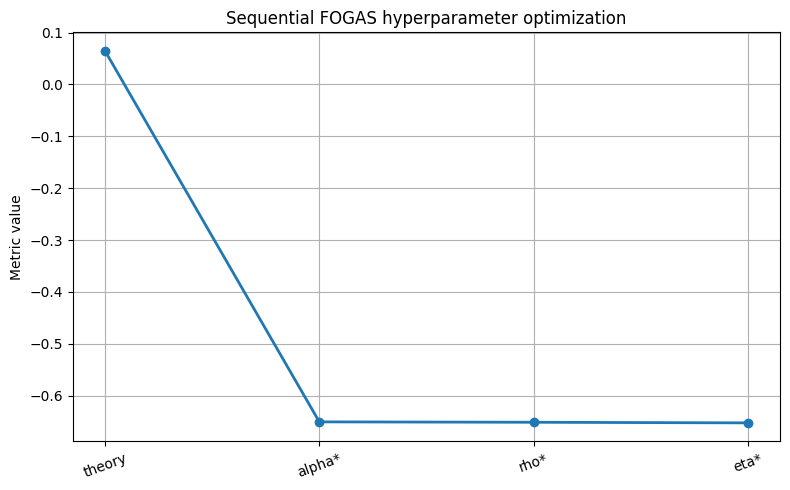

In [80]:
summary = optimizer.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=20,
    print_main=True, 
    num_runs=2,
    order=("alpha", "rho", "eta")
)

alpha_star = summary["alpha"]
rho_star = summary["rho"]
eta_star = summary["eta"]

In [81]:
solver.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator.compare_value_functions()

FOGAS Oracle:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS Oracle: 100%|██████████| 1500/1500 [00:00<00:00, 7593.05it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526610 | Δ = -8.276947e-09
State 1: V*(x) =  5.863949 | V^π(x) = -8.114815 | Δ = -1.397876e+01
State 2: V*(x) =  5.267554 | V^π(x) = -9.005350 | Δ = -1.427290e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262900 | Δ = -9.149043e-09
State 4: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -2.028674e-09
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.081000 | Δ = -1.016561e-08
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ = -2.254081e-09
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526610 | Δ = -8.234139e-09
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863949 | Δ = -7.449253e-09
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.313334 |

In [82]:
evaluator.print_policy()

  State 0: π(a=0|s=0) = 0.00  π(a=1|s=0) = 1.00  π(a=2|s=0) = 0.00  π(a=3|s=0) = 0.00  --> best action: 1
  State 1: π(a=0|s=1) = 0.00  π(a=1|s=1) = 0.00  π(a=2|s=1) = 0.00  π(a=3|s=1) = 1.00  --> best action: 3
  State 2: π(a=0|s=2) = 0.00  π(a=1|s=2) = 0.99  π(a=2|s=2) = 0.00  π(a=3|s=2) = 0.01  --> best action: 1
  State 3: π(a=0|s=3) = 0.00  π(a=1|s=3) = 1.00  π(a=2|s=3) = 0.00  π(a=3|s=3) = 0.00  --> best action: 1
  State 4: π(a=0|s=4) = 0.00  π(a=1|s=4) = 1.00  π(a=2|s=4) = 0.00  π(a=3|s=4) = 0.00  --> best action: 1
  State 5: π(a=0|s=5) = 0.25  π(a=1|s=5) = 0.25  π(a=2|s=5) = 0.25  π(a=3|s=5) = 0.25  --> best action: 0
  State 6: π(a=0|s=6) = 0.00  π(a=1|s=6) = 0.00  π(a=2|s=6) = 0.00  π(a=3|s=6) = 1.00  --> best action: 3
  State 7: π(a=0|s=7) = 0.00  π(a=1|s=7) = 0.00  π(a=2|s=7) = 0.00  π(a=3|s=7) = 1.00  --> best action: 3
  State 8: π(a=0|s=8) = 0.25  π(a=1|s=8) = 0.25  π(a=2|s=8) = 0.25  π(a=3|s=8) = 0.25  --> best action: 0



### Empirical

In [83]:
solver_e = FOGASSolverVectorized(
    mdp=mdp, 
    print_params=True, 
    csv_path=str(DATASET_PATH),
    T=1500,
    device=device,
)
evaluator_e = FOGASEvaluator(solver_e)
optimizer_e = FOGASHyperOptimizer(solver=solver_e,metric_callable=evaluator_e.get_metric("reward"), seed=seed)



================ FOGAS PARAMETER SUMMARY ================

Basic Information
-----------------
Dataset size n:           1000
Feature norm bound R:     1.4142
Num states N:             9
Num actions A:            4
Feature dim d:            27
Discount γ:               0.9
Confidence δ:             0.05

Theoretical Quantities
----------------------
T_min (theoretical):      1851.025705278074
T (iterations):                1500   (overridden → 1500)

FOGAS Hyperparameters
---------------------
alpha:                        0.000585
rho:                            455.951925
eta:                            0.000013
D_theta:                    16.431677
beta (ridge):             0.000049
D_pi (derived):           14.420269




In [84]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 2620.02it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |


=== FOGAS Hyperparameter Optimization ===
[Initial] metric = -0.0118
Order: ('alpha', 'rho', 'eta')

Optimizing alpha
[After alpha*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing rho
[After rho*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527

Optimizing eta
[After eta*] alpha=4.4392e+00, rho=3.0000e+00, eta=1.0000e-02 | metric = -0.6527


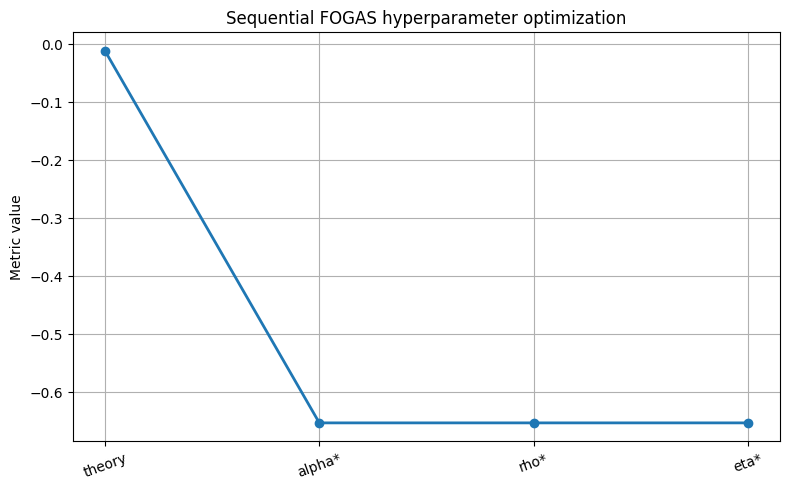

In [86]:
summary_e = optimizer_e.optimize_fogas_hyperparameters(
    search_method="random",
    coarse_points=15,
    print_main=True, 
    num_runs=1,
    random_candidates=30,
    order=("alpha", "rho", "eta"),
    bounds_overrides={"alpha" : (1e-2, 5.0), "rho" : (1e-2, 3.0), "eta" : (1e-2, 3.0)}
)

alpha_star_e = summary_e["alpha"]
rho_star_e = summary_e["rho"]
eta_star_e = summary_e["eta"]

In [89]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |

In [ ]:
solver_e.run(alpha=alpha_star, eta=eta_star, rho=rho_star, tqdm_print=True)
evaluator_e.compare_value_functions()
evaluator_e.compare_final_rewards()

FOGAS:   0%|          | 0/1500 [00:00<?, ?it/s]

FOGAS: 100%|██████████| 1500/1500 [00:00<00:00, 3011.51it/s]


========== VALUE FUNCTION COMPARISON ==========

State-wise V comparison:
State 0: V*(x) =  6.526610 | V^π(x) =  6.526608 | Δ = -1.714968e-06
State 1: V*(x) =  5.863949 | V^π(x) = -8.083519 | Δ = -1.394747e+01
State 2: V*(x) =  5.267554 | V^π(x) = -8.970577 | Δ = -1.423813e+01
State 3: V*(x) =  7.262900 | V^π(x) =  7.262898 | Δ = -1.644371e-06
State 4: V*(x) =  8.081000 | V^π(x) = -0.421890 | Δ = -8.502890e+00
State 5: V*(x) = -10.000000 | V^π(x) = -10.000000 | Δ =  0.000000e+00
State 6: V*(x) =  8.081000 | V^π(x) =  8.080998 | Δ = -1.827079e-06
State 7: V*(x) =  8.990000 | V^π(x) =  8.990000 | Δ =  0.000000e+00
State 8: V*(x) =  10.000000 | V^π(x) =  10.000000 | Δ =  0.000000e+00

Action-value Q comparison:
(x=0, a=0): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=1): Q*(x,a) =  6.526610 | Q^π(x,a) =  6.526609 | Δ = -1.479934e-06
(x=0, a=2): Q*(x,a) =  5.863949 | Q^π(x,a) =  5.863947 | Δ = -1.543471e-06
(x=0, a=3): Q*(x,a) =  5.267554 | Q^π(x,a) = -7.285167 |